In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from tqdm import tqdm

from models.flow import build_model
from models.utils import standard_normal_logprob

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [2]:
df = pd.read_csv('data/xgboostlss/train_sim.csv')

In [3]:
df

,y,x,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,7.674012,0.916298,0.527137,0.635617,0.493145,0.344755,0.576426,0.790296,0.003594,0.445776,0.101779,0.820447
1,7.247328,0.335736,0.394122,0.538305,0.991252,0.963605,0.069468,0.201859,0.960596,0.200165,0.265419,0.404680
2,7.446702,0.364092,0.348935,0.257174,0.386638,0.752369,0.279995,0.712555,0.019349,0.559537,0.424546,0.016045
3,2.212709,0.354783,0.371568,0.659342,0.873968,0.608841,0.619594,0.409291,0.016852,0.210096,0.767399,0.785347
4,10.570977,0.457633,0.573644,0.945059,0.413363,0.071302,0.396778,0.088565,0.767333,0.614261,0.185449,0.604649
...,...,...,...,...,...,...,...,...,...,...,...,...
6995,3.213847,0.353606,0.735342,0.728736,0.097127,0.544585,0.456196,0.462667,0.160362,0.261871,0.591258,0.629825
6996,10.621667,0.213697,0.740343,0.070541,0.412572,0.860822,0.455373,0.720614,0.151872,0.725876,0.223983,0.437281
6997,6.760315,0.782918,0.475747,0.971335,0.354660,0.003654,0.106532,0.107143,0.830433,0.671432,0.368331,0.831553
6998,18.432021,0.359430,0.185189,0.365285,0.595911,0.907491,0.794568,0.943300,0.565046,0.907944,0.916980,0.529689


In [4]:
x, y = df['x'].values, df[['y']].values

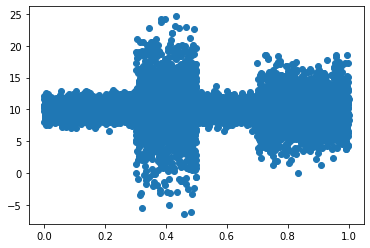

In [5]:
plt.scatter(x, y)
plt.show()

In [6]:
x, y = torch.Tensor(x).to(DEVICE), torch.Tensor(y).to(DEVICE)

In [7]:
flow = build_model(
    input_dim=1,
    hidden_dims=(2,),
    context_dim=1,
    num_blocks=1,
    conditional=True,
    time_length=1.0,
    batch_norm=True,
    layer_type="concatscale"
).to(DEVICE)

optimizer = optim.Adam(flow.parameters())

In [8]:
num_iter = 5000

with tqdm(range(num_iter)) as pbar:
    for i in pbar:
        ind = torch.randperm(len(x))[:1000]
        
        iks, context = y[ind], x[ind]
        optimizer.zero_grad()

        zero = torch.zeros(iks.shape[0], 1).to(DEVICE)
        z, delta_logp = flow(x=iks, context=context, logpx=zero)  # run model forward

        logpz = standard_normal_logprob(z).view(z.shape[0], -1).sum(1, keepdim=True)  # logp(z)
        logpx = logpz - delta_logp

        loss = -logpx.mean()
        pbar.set_description(f"Loss {loss:.2f}")

        loss.backward()
        optimizer.step()

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torchdiffeq/_impl/misc.py:326: UserWarning: torch.nextafter is only available in PyTorch 1.7 or newer.Falling back to numpy.nextafter. Upgrade PyTorch to remove this warning.
  warnings.warn("torch.nextafter is only available in PyTorch 1.7 or newer."
Loss 2.24: 100%|██████████| 5000/5000 [20:40<00:00,  4.03it/s]


In [9]:
n_samples = 50

x_new = torch.linspace(0, 1, 51).repeat(n_samples).to(DEVICE)
z = torch.randn(len(x_new), 1).to(DEVICE)

y = flow(x=z, context=x_new, reverse=True)
y = y.detach().cpu().numpy()

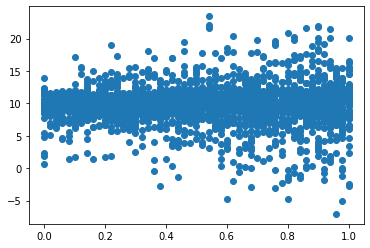

In [10]:
plt.scatter(x_new.detach().cpu().numpy(), y)
plt.show()